Implementation of _Weight Uncertainty in Neural Networks_, Charles Blundell et al., May 2015

In [1]:
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from scipy import optimize, stats
import seaborn as sns
sns.set()
import pandas as pd

# Linear Regression

We start with the simplest possible setting: linear regression; this will make it easy to plot the model and to examine the optimization process.

In [2]:
N = 250
true_parameters = np.array([3, -2])

X = np.random.random(size=(N, 2)) * 4 - 2
X[:, 1] = 1
eps = np.random.normal(scale=0.75, size=(N,))

y = X.dot(true_parameters) + eps

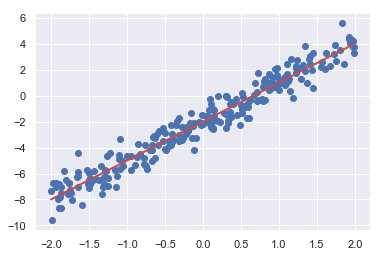

In [3]:
plt.scatter(X[:, 0], y)
plt.plot([-2, 2], [-2 * 3 - 2, 2 * 3 - 2], 'r', linewidth=2)

We should choose the proper standard deviation for the prior; if it's too low, the prior would be too strong and favor parameters close to zero. In this case we can cheat and actually check how much regularization would result in the best prior likelihood for the parameters:

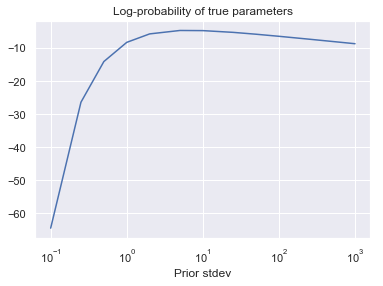

In [4]:
covs = [0.1, 0.25, 0.5, 1, 2, 5, 10, 25, 50, 100, 250, 500, 1000]
ps = [
    stats.multivariate_normal(
        mean=np.zeros(2),
        cov=c * np.eye(2)
    ).logpdf(true_parameters)
    for c in covs
]

plt.semilogx(covs, ps)
plt.xlabel('Prior stdev')
plt.title('Log-probability of true parameters')
plt.show()

We can safely pick a prior standard deviation of 2.


Short anecdote: initially I didn't know which value to choose, so I randomly chose for 0.1, for no particular reason. After I finished the implementation, the parameters found by gradient descent were not that good, but not so bad that you would think something bad was going on. Then, after some head-scratching, I checked the three components of the loss, and found that the true parameters had indeed larger likelihood, but their loss was heavily influenced by the penalty due to the prior. I ran everything with a larger prior standard deviation and everything went smoothly.

We now apply the variational method proposed in the paper, where we use Gaussians everywhere (prior, approximate posterior, and likelihood).

In [5]:
class GradientDescentOptimizer:
    def __init__(self, momentum=0.9, base_lrate=1, clip_gradient=1,
                 min_improvement=1e-3, max_steps=1000, verbose=0,
                 raise_exceptions=False):
        self.momentum = momentum
        self.base_lrate = base_lrate
        self.clip_gradient = clip_gradient
        self.min_improvement = min_improvement
        self.max_steps = max_steps
        self.verbose = verbose
        self.raise_exceptions = raise_exceptions

    def log(self, level, *message):
        if level <= self.verbose:
            print(*message)

    def minimize(self, initial, f, *f_args):
        old_gradient = None
        old_value = np.inf
        parameters = initial
        base_lrate = self.base_lrate
        best = old_value, parameters
        
        self.hist = []
        for i in range(self.max_steps):
            try:
                value, gradient = f(parameters, *f_args)
            except Exception as exc:
                if self.raise_exceptions:
                    raise
                else:
                    self.log(0, exc)
                    break

            # update best guess
            if value < best[0]:
                best = value, parameters

            # halve learning rate if function increased
            # NB: in this case, the function is approximated with monte carlo sampling
            # which means it is potentially very noisy, therefore cannot interpret
            # the value decreasing as 
            if value > old_value:
                #base_lrate *= 0.5
                pass

            # decay learning rate
            lrate = base_lrate / np.sqrt(i + 1)

            # clip gradient
            mag = np.sqrt(np.sum(gradient**2))
            if self.clip_gradient > 0 and mag > self.clip_gradient:
                gradient = gradient * self.clip_gradient / mag

            # apply momentum
            if old_gradient is not None:
                gradient = self.momentum * old_gradient + (1 - self.momentum) * gradient

            # update, log and check for stopping criterion
            parameters -= lrate * gradient

            self.hist.append((i, value, old_value - value, lrate, mag, parameters.copy()))
            self.log(2, 'IT: %6d | LLI: %14.3f | IM: %14.3e | LR: %14.3e | MAG: %14.3f - %s' % self.hist[-1])

            if i > 10 and abs(value - old_value) < self.min_improvement:
                break

            old_value, old_gradient = value, gradient

        return best

    def minimize_with_restarts(self, num_restarts, sample_initial, f, *f_args):
        best, hist = None, None
        for i in range(num_restarts):
            parameters = sample_initial()
            value, parameters = self.minimize(parameters, f, *f_args)
            if best is None or value < best[0]:
                best = value, parameters
                hist = self.hist
                
            self.log(1, '--------------------- %d - Got: %.4f - Best: %.4f' % (i + 1, value, best[0]))
            self.log(1, '----', parameters)

        self.hist = hist
        return best

In [270]:
def sample_and_loss(mu, rho, eps, X, y, regu, sigma_noise):
    ''' sample one set of parameters and compute loss and gradients
    '''
    
    sigma = np.log(1 + np.exp(rho))
    w = mu + sigma * eps
    
    log_q = -0.5 * np.log(2 * np.pi) - np.log(sigma) - (w - mu)**2 / (2 * sigma**2)
    log_p = -0.5 * np.log(2 * np.pi) - np.log(regu) - w**2 / (2 * regu**2)

    preds = X.dot(w)
    log_d = -0.5 * np.log(2 * np.pi) - np.log(sigma_noise) - (preds - y)**2 / (2 * sigma_noise**2)
    
    loss = np.sum(log_q) - np.sum(log_p) - np.sum(log_d)

    # compute gradient of loss wrt w
    dlogq_dw = -(w - mu) / sigma**2
    dlogp_dw = -w / regu**2
    dlogd_dw = np.sum(
        -X.T * (preds - y).T / sigma_noise**2,
        axis=1
    )
    dloss_dw = dlogq_dw - dlogp_dw - dlogd_dw

    # compute gradient of loss wrt mu
    dlogq_dmu = np.zeros(mu.shape)
    dlogp_dmu = dlogp_dw
    dlogd_dmu = dlogd_dw
    dloss_dmu = dlogq_dmu - dlogp_dmu - dlogd_dw
    
    # compute gradient of loss wrt rho
    dsigma_drho = np.exp(rho) / (1 + np.exp(rho))
    dw_dsigma = eps
    
    dlogq_drho = -dsigma_drho / sigma
    dlogp_drho = dlogp_dw * dw_dsigma * dsigma_drho
    dlogd_drho = dlogd_dw * dw_dsigma * dsigma_drho
    dloss_drho = dlogq_drho - dlogp_drho - dlogd_drho
    
    return loss, w, dloss_dw, dloss_dmu, dloss_drho


def compute_loss(mu, rho, X, y, regu, sigma_noise, reps=100):
    ''' approximate the loss and the gradients by monte carlo sampling 
    '''
    acc = None
    for i in range(reps):
        eps = np.random.normal(size=rho.shape[0])
        loss, w, dloss_dw, dloss_dmu, dloss_drho = sample_and_loss(
            mu, rho, eps, X, y, regu, sigma_noise
        )
        
        gradient_mu = dloss_dw + dloss_dmu
        gradient_rho = dloss_dw * eps / (1 + np.exp(-rho)) + dloss_drho
        
        res = [loss, gradient_mu, gradient_rho]
        
        if acc is None:
            acc = res
        else:
            for a, r in zip(acc, res):
                a += r

    return [a if i == 0 else a / reps for i, a in enumerate(acc)]

Check the gradients for a single sample. Averaged gradients are too noisy to be checked with finite differences.

In [23]:
mu = np.array([-0.01, 0.5])
rho = np.array([0.2, 0.1])
eps = np.array([-2, 3])
regu = 2
sigma_noise = 0.75


def gradient_check(f, x0, eps=1e-9):
    loss, gradient = f(x0)
    
    for i in range(x0.shape[0]):
        noise = np.zeros(shape=x0.shape)
        noise[i] = eps
        
        loss_neg, _ = f(x0 - noise)
        loss_pos, _ = f(x0 + noise)
        fdiff = (loss_pos - loss_neg) / (2 * eps)
        
        print('Analytical Gradient: %.4f - Finite Differences Gradient: %.4f' %(
            gradient[i], fdiff
        ))
    
        assert np.allclose(gradient[i], fdiff)


print('Checking gradient of mu')
gradient_check(
    lambda x: itemgetter(0, 3)(sample_and_loss(x, rho, eps, X, y, regu, sigma_noise)),
    x0=mu
)

print('\nChecking gradient of rho')
gradient_check(
    lambda x: itemgetter(0, 4)(sample_and_loss(mu, x, eps, X, y, regu, sigma_noise)),
    x0=rho
)

Checking gradient of mu
Analytical Gradient: -2488.8033 - Finite Differences Gradient: -2488.8031
Analytical Gradient: 2156.2910 - Finite Differences Gradient: 2156.2919

Checking gradient of rho
Analytical Gradient: 2736.1684 - Finite Differences Gradient: 2736.1684
Analytical Gradient: 3395.3184 - Finite Differences Gradient: 3395.3202


Sample random parameters, plot loss and find minimum

In [24]:
values = []
for i in range(1000):
    params = 20 * (np.random.random(size=2) - 0.5)
    ll, *_ = compute_loss(
        params, np.array([-8, -8]), X, y, 2, 0.75
    )
    ll = np.log(ll)
    values.append((params, ll))


aa = np.array([(x, y, z) for (x, y), z in values])
min_w0, min_w1, min_loss = aa[aa[:, 2].argmin()]
print('Minimum loss: %.4f at (%.4f, %.4f)' % (np.exp(min_loss), min_w0, min_w1))

Minimum loss: 346.2275 at (2.9631, -2.3887)


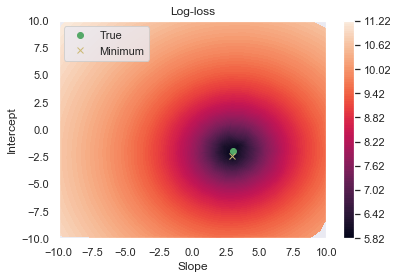

In [25]:
plt.tricontourf(aa[:, 0], aa[:, 1], aa[:, 2], levels=100)
plt.plot(3, -2, 'o', color='g', label='True')
plt.plot(min_w0, min_w1, 'x', color='y', label='Minimum')
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.colorbar()
plt.title('Log-loss')
plt.legend(loc='upper left')
plt.show()

The variance of the loss estimate depends on the value of $\rho$: 

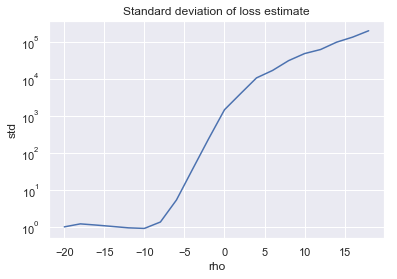

In [26]:
all_losses = []
for rho in range(-20, 20, 2):
    lss = [
        compute_loss(mu, np.array([rho, rho]), X, y, regu, sigma_noise, reps=1)[0]
        for _ in range(100)
    ]
    all_losses.append((rho, np.mean(lss), np.std(lss)))
all_losses = np.array(all_losses)

plt.semilogy(all_losses[:, 0], all_losses[:, 2])
plt.xlabel('rho')
plt.ylabel('std')
plt.title('Standard deviation of loss estimate')
plt.show()

Now we can optimize the parameters using gradient descent. The loss and gradients are very noisy, especially at the beginning of training. There are two ways of fighting against the noise: (a) is to take a lot of samples to obtain reliable estimates of the gradients, and (b) is to take few, or even just one, samples and use high momentum, so as to downplay the influence of the noise. We are going to showcase both approaches.

In [215]:
def do_training(num_samples, momentum):
    ''' num_samples: how many samples to use to approximate loss and gradients
        momentum: momentum to apply during gradient descent
        lrate: initial learning rate for gradient descent
    '''
    def target_f(parameters):
        param_count = len(parameters) // 2
        mu, rho = parameters[:param_count], parameters[param_count:]

        loss, gradient_mu, gradient_rho = compute_loss(
            mu, rho, X, y, regu=2, sigma_noise=0.75,
            reps=num_samples
        )

        gradient = np.zeros(2 * param_count)
        gradient[:param_count] = gradient_mu
        gradient[param_count:] = gradient_rho

        return loss, gradient
    
    opt = GradientDescentOptimizer(
        base_lrate=0.1,
        momentum=momentum,
        verbose=0,
        min_improvement=1e-4,
        raise_exceptions=True,
        max_steps=int(1e4),
    )

    loss, parameters = opt.minimize_with_restarts(
        5,
        lambda: np.random.normal(size=4),
        target_f
    )

    print('Best loss %.4f with parameters %s' % (loss, parameters))
    return opt.hist

In [216]:
%time many_samples = do_training(num_samples=100, momentum=0)

Best loss 292.5780 with parameters [ 2.99521317 -1.98013771 -3.05440713 -2.96506781]
CPU times: user 1min 47s, sys: 641 ms, total: 1min 48s
Wall time: 1min 47s


In [217]:
%time high_momentum = do_training(num_samples=1, momentum=0.99)

Best loss 292.3053 with parameters [ 2.98143281 -1.97662811 -2.10653608 -1.95327764]
CPU times: user 9.8 s, sys: 76.7 ms, total: 9.87 s
Wall time: 9.82 s


In [275]:
true_loss, *_ = compute_loss(true_parameters, np.array([-8, -8]), X, y, regu=2, sigma_noise=0.75, reps=100)
true_loss

307.5327710538455

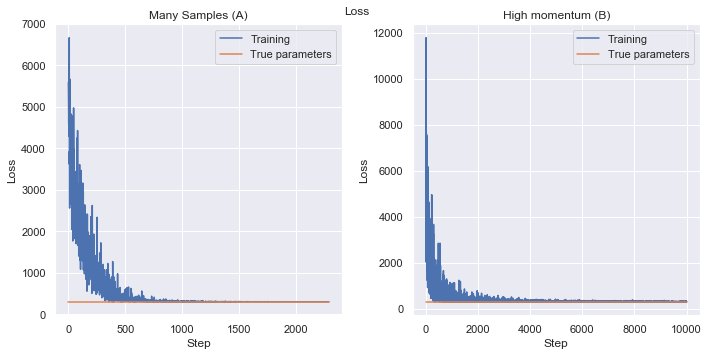

In [226]:
def plot_loss(hist):
    plt.plot([x[1] for x in hist], label='Training')
    plt.plot([0, len(hist)], [true_loss, true_loss], label='True parameters')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')


plt.figure(figsize=(10, 5))
plt.suptitle('Loss')

plt.subplot(1, 2, 1)
plt.title('Many Samples (A)')
plot_loss(many_samples)

plt.subplot(1, 2, 2)
plt.title('High momentum (B)')
plot_loss(high_momentum)

plt.tight_layout()
plt.show()

Notice the different scale in the y axis!

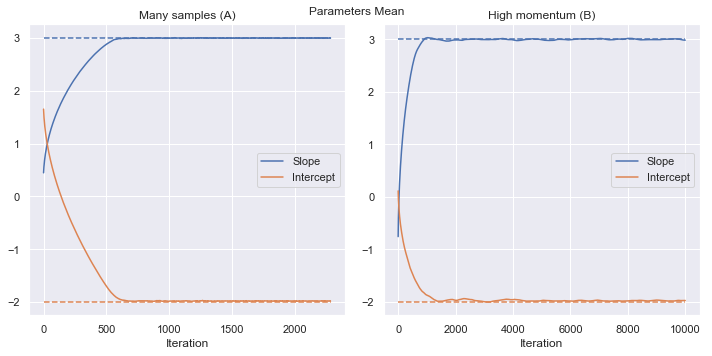

In [227]:
def plot_parameters_mean(hist):
    plt.plot([x[-1][0] for x in hist], label='Slope', color='C0')
    plt.plot([0, len(hist)], [true_parameters[0], true_parameters[0]], '--', color='C0')
    plt.plot([x[-1][1] for x in hist], label='Intercept', color='C1')
    plt.plot([0, len(hist)], [true_parameters[1], true_parameters[1]], '--', color='C1')
    plt.xlabel('Iteration')
    plt.legend()

    
plt.figure(figsize=(10, 5))
plt.suptitle('Parameters Mean')

plt.subplot(1, 2, 1)
plt.title('Many samples (A)')
plot_parameters_mean(many_samples)

plt.subplot(1, 2, 2)
plt.title('High momentum (B)')
plot_parameters_mean(high_momentum)

plt.tight_layout()
plt.show()

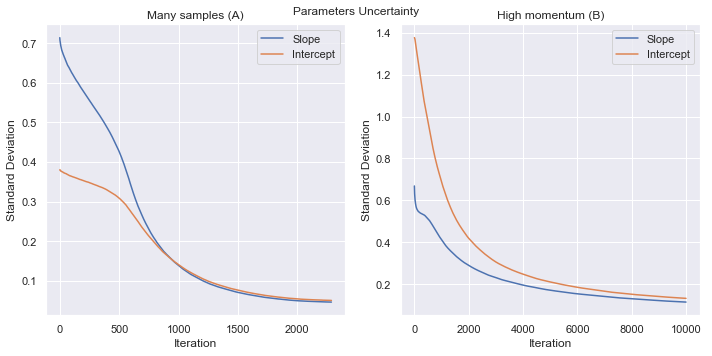

In [230]:
def plot_parameters_sigma(hist):
    plt.plot([np.log(1 + np.exp(x[-1][2])) for x in hist], label='Slope', color='C0')
    plt.plot([np.log(1 + np.exp(x[-1][3])) for x in hist], label='Intercept', color='C1')
    plt.legend()
    plt.ylabel('Standard Deviation')
    plt.xlabel('Iteration')
    
    
plt.figure(figsize=(10, 5))
plt.suptitle('Parameters Uncertainty')

plt.subplot(1, 2, 1)
plt.title('Many samples (A)')
plot_parameters_sigma(many_samples)

plt.subplot(1, 2, 2)
plt.title('High momentum (B)')
plot_parameters_sigma(high_momentum)

plt.tight_layout()
plt.show()

Observations:

 - Method A takes much longer wall clock time, but requires much fewer parameter updates
 - At the beginning, the gradient updates are dominated by changes in the parameters mean
 - Significant updates in the parameters uncertainty only happen when the means have converged (notice the change in slope)
 - Most of the updates are spent on decreasing $\rho$, while keeping the means at the same values.
 - $\rho$ has great influence on the noise of the loss function and gradients)

Notice that the solutions obtained are different from true posterior, since in that case the parameters are usually correlated, whereas in this approximation they are forcefully independent. The mean parameters, however, are very close to the true ones. For reference, the parameters found by the traditional exact solution to linear regression, and their loss, are:

In [289]:
exact_weights = np.linalg.inv(X.T.dot(X) + 2 * np.eye(2)).dot(X.T).dot(y)
exact_loss, *_ = compute_loss(exact_weights, np.array([-8, -8]), X, y, regu=2, sigma_noise=0.75, reps=1)
exact_weights, exact_loss

(array([ 2.97757599, -1.96496295]), 306.83079509939506)